<a href="https://colab.research.google.com/github/AnnSenina/databases_stat_2023/blob/main/notebooks/XML_%D0%B8_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. XML и Beautiful Soup

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

## BeautifulSoup - парсер прежде всего html

Но и с xml умеет работать - причем будет работать даже лучше, есои явно указать, что у нас xml

In [ ]:
markup = '''
<html>
    <head>
        <title>Устав ООН</title>
    </head>
    <body>
        <h1>Преамбула</h1>
        <p>Мы, народы объединенных наций, преисполненные решимости <b>избавить грядущие поколения 
        от бедствий войны</b>, дважды в нашей жизни принесшей человечеству невыразимое горе, 
        и  вновь утвердить веру в основные права человека, в достоинство и ценность человеческой личности, 
        в равноправие мужчин и женщин и в <b>равенство прав больших и малых наций</b>, 
        и  создать условия, при которых могут соблюдаться справедливость и уважение к обязательствам, 
        вытекающим из договоров и других источников международного права, и  
        содействовать социальному прогрессу и улучшению условий жизни при большей свободе</p>
    </body>
</html>
'''
soup = BeautifulSoup(markup, 'xml')
print(soup.prettify())

In [ ]:
soup.title

In [ ]:
soup.title.text

In [ ]:
soup.p.text

### ⛳ 💻 Пример в коде
парсим XML

Вот здесь лежит TEI/XML с пьесой "Смерть Иоанна Грозного": https://dracor.org/api/corpora/rus/play/tolstoy-smert-ioanna-groznogo/tei


In [13]:
grozniy_xml_as_text = requests.get('https://dracor.org/api/corpora/rus/play/tolstoy-smert-ioanna-groznogo/tei').text

In [14]:
soup = BeautifulSoup(grozniy_xml_as_text, 'xml')

In [ ]:
soup

In [ ]:
soup.title.text

In [ ]:
soup.author

Давайте вытащим из этого xml все элементы `<sp>` (реплика персонажа), внутри которых есть `<stage>` (авторская ремарка) с текстом содержащим слово уход, уходить, уходят и т.п. Сделаем датафрейм такого вида: 

<img src="https://github.com/Python-4-Digital-Humanities/data_for_classes/raw/main/xml/task_version1.png">

In [ ]:
all_data = []

for stage in soup.find_all('stage'):
    parent = stage.parent
    if parent.name == 'sp' and 'уход' in stage.text:
        who_speaks = parent['who']
        stage_text = stage.text
        entire_text = parent.text 
        all_data.append({'кто говорит': who_speaks, 'авторская ремарка': stage_text, 'полный текст реплики': entire_text})

pd.DataFrame(all_data)

# 2. Язык XML, язык запросов `xPath` и библиотека `lxml`

XML — это древесная структура с четкой иерархической вложенностью элементов. Теги вложены в другие теги примерно как папки на компьютере:

<img src="http://docs.vizrt.com/graphic-hub-guide/2.3/graphics/tree.png">

Так почему бы нам не использовать тот же подход, что при писании путей? 

Ведь на компьютере мы можем выражать пути вот так: 

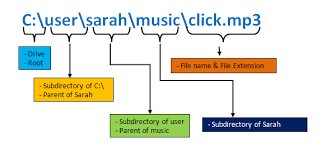

Тогда первоначальный запрос в предыдущем задание можно было бы описать очень компактно и без всяких циклов:

In [ ]:
soup.find_all('//sp/stage')

Не работает. Но на самом деле именно такого вида навигация по XML/HTML существует — и называется она **xPath**. Просто поддержки xPath [нет](https://stackoverflow.com/questions/11465555/can-we-use-xpath-with-beautifulsoup) в bs4, но он доступен в python благодаря второй библиотеке — lxml. 


### Импортируем etree из библиотеки lxml

In [21]:
from lxml import etree

Подтянем сначала небольшой образец:

In [22]:
teachers_xml = requests.get('https://raw.githubusercontent.com/dhhse/dh2020/master/xml/dhhse.xml')

In [ ]:
print(teachers_xml.text)

In [ ]:
soup = BeautifulSoup(teachers_xml.text)
soup.find_all('person')

Воспользуемся методом `etree.fromstring()` -- это похоже на  конструкцию `BeautifulSoup()`, только строку придется перевести в байткод с помощью метода `encode()`:

In [ ]:
xml_to_parse = teachers_xml.text.encode('utf-8')
xml_to_parse

In [27]:
parsed_XML = etree.fromstring(xml_to_parse)

In [ ]:
for person in parsed_XML.findall('.//person'):
    print(person.tag)
    print(person.attrib['age'])

In [ ]:
len(parsed_XML.findall('.//person'))

In [ ]:
for element in parsed_XML.findall('.//teachers//surname'):
    print (element.text)

При помощи xPath мы можем описать произвольный кусочек пути  в нашем дереве — это довольно гибкий инструмент. Например, все  теги, которые находятся где-то под person:

In [ ]:
for element in parsed_XML.findall('.//person//*'):
    print (element.tag, element.text)